In [271]:
import numpy as np
import pandas as pd
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn import ensemble
import seaborn as sns
import math
import matplotlib.pyplot as plt

In [272]:
train = pd.read_csv("C:/Users/bodak/Desktop/train1.csv")
test = pd.read_csv("C:/Users/bodak/Desktop/test1.csv")

In [273]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [274]:
num = train.select_dtypes(exclude='object')
numcorr = num.corr()
Num = numcorr['SalePrice'].sort_values(ascending=False).to_frame()

In [275]:
Num   #correlation between features and target

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897


In [276]:
na = train.shape[0]
y_train = train['SalePrice'].to_frame()
combine = pd.concat((train, test), sort=False).reset_index(drop=True)

In [277]:
#Data cleaning
#Dropping features with lots of missing data

combine = combine.drop(['FireplaceQu'], axis = 1)
combine = combine.drop(['PoolQC'], axis = 1)
combine = combine.drop(['Fence'], axis = 1)
combine = combine.drop(['MiscFeature'], axis = 1)
combine = combine.drop(['Alley'], axis = 1)
combine = combine.drop(['SalePrice'], axis = 1)

In [278]:
allna = combine.isnull().sum()
allna = allna.drop(allna[allna == 0].index).sort_values(ascending=False)

In [279]:
allna.to_frame()   #amount of missed values for each feature

,0
LotFrontage,486
GarageQual,159
GarageFinish,159
GarageYrBlt,159
GarageCond,159
GarageType,157
BsmtExposure,82
BsmtCond,82
BsmtQual,81
BsmtFinType2,80


In [280]:
#Filling NA

combine['LotFrontage'] = combine['LotFrontage'].fillna(0)
combine['GarageQual'] = combine['GarageQual'].fillna('NA')
combine['GarageFinish'] = combine['GarageFinish'].fillna('NA')
combine['GarageYrBlt'] = combine['GarageYrBlt'].fillna(combine['GarageYrBlt'].median())
combine['GarageCond'] = combine['GarageCond'].fillna('NA')
combine['GarageType'] = combine['GarageType'].fillna('NA')
combine['BsmtExposure'] = combine['BsmtExposure'].fillna('NA')
combine['BsmtCond'] = combine['BsmtCond'].fillna('NA')
combine['BsmtQual'] = combine['BsmtQual'].fillna('NA')
combine['BsmtFinType2'] = combine['BsmtFinType2'].fillna('NA')
combine['BsmtFinType1'] = combine['BsmtFinType1'].fillna('NA')
combine['MasVnrType'] = combine['MasVnrType'].fillna('None')
combine['MasVnrArea'] = combine['MasVnrArea'].fillna(0)
combine['MSZoning'] = combine['MSZoning'].fillna('RL')

In [281]:
combine['BsmtFullBath'] = combine['BsmtFullBath'].fillna(method='ffill')
combine['BsmtHalfBath'] = combine['BsmtHalfBath'].fillna(method='ffill')
combine['Functional'] = combine['Functional'].fillna(method='ffill')
combine['Utilities'] = combine['Utilities'].fillna(method='ffill')
combine['Exterior2nd'] = combine['Exterior2nd'].fillna(method='ffill')
combine['Exterior1st'] = combine['Exterior1st'].fillna(method='ffill')
combine['SaleType'] = combine['SaleType'].fillna(method='ffill')
combine['BsmtFinSF1'] = combine['BsmtFinSF1'].fillna(method='ffill')
combine['BsmtFinSF2'] = combine['BsmtFinSF2'].fillna(method='ffill')
combine['TotalBsmtSF'] = combine['TotalBsmtSF'].fillna(method='ffill')
combine['Electrical'] = combine['Electrical'].fillna(method='ffill')
combine['KitchenQual'] = combine['KitchenQual'].fillna(method='ffill')
combine['GarageCars'] = combine['GarageCars'].fillna(method='ffill')
combine['GarageArea'] = combine['GarageArea'].fillna(method='ffill')
combine['BsmtUnfSF'] = combine['BsmtUnfSF'].fillna(method='ffill')

In [282]:
#Creating new features

combine['TotalArea'] = combine['TotalBsmtSF'] + combine['1stFlrSF'] + combine['2ndFlrSF'] + combine['GrLivArea'] + combine['GarageArea']
combine['YearAvrg'] = (combine['YearBuilt'] + combine['YearRemodAdd'])/2
combine['TotalBsmtFin'] = combine['BsmtFinSF1'] + combine['BsmtFinSF2']
combine['TotalBath'] = combine['FullBath'] + combine['HalfBath'] + combine['BsmtFullBath'] + combine['BsmtHalfBath']

In [283]:
#using get_dummies

combine_dummies=pd.get_dummies(combine)

In [284]:
Train = combine_dummies[:na]
Test = combine_dummies[na:]

In [285]:
y=np.array(y_train)

In [286]:
#splitting data

x_train, x_test, y_train, y_test = train_test_split(Train, y,test_size = .3, random_state=0)

In [287]:
#scaling data

scaler= RobustScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
X_test= scaler.transform(Test)

In [290]:
#using GBRegressor model

params = {'n_estimators': 1300, 'max_depth': 5, 'min_samples_split': 5,
          'learning_rate': 0.01}
gbr1 = ensemble.GradientBoostingRegressor(**params)
gbr1.fit(x_train, y_train)
y_subm = gbr1.predict(X_test)
y_pred = gbr1.predict(x_test)

C:\Users\bodak\Miniconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [291]:
print('Root Mean Square Error test = ' + str(math.sqrt(mean_squared_error(y_test, y_pred))))
print(r2_score(y_test, y_pred))

Root Mean Square Error test = 27127.872314832166
0.8916007682835668


In [294]:
#fitting model parameters

params1 = {'learning_rate': [0.01],
                  'min_samples_split': [2, 3 ,4, 5],
                  'n_estimators' : [1000, 1300, 1500, 2000, 2500],
                  'max_depth'    : [3, 4, 5]
                 }

In [295]:
rs = GridSearchCV(estimator=gbr1, param_grid = params1, cv = 2, n_jobs=-1)

In [296]:
rs.fit(x_train, y_train)
best_est = rs.best_estimator_
print(best_est)

C:\Users\bodak\Miniconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.01, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=4,
                          min_weight_fraction_leaf=0.0, n_estimators=1500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


In [300]:
print(rs.best_score_)
print(rs.best_params_)

0.8559753333469855
{'learning_rate': 0.01, 'max_depth': 3, 'min_samples_split': 4, 'n_estimators': 1500}


In [292]:
predictors = Train.keys()

Text(0, 0.5, 'Feature Importance Score')

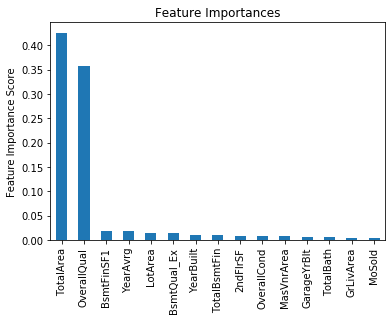

In [293]:
feat_imp = pd.Series(gbr1.feature_importances_, predictors).sort_values(ascending=False).head(15)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [ ]:
submission = pd.DataFrame({
        "Id": test["Id"],
        "SalePrice": y_subm })
submission.to_csv('C:/Users/bodak/Desktop/my_submission.csv', index = False)